In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy

# Q1 Directional Filtering

In [3]:
M = 256
x1 = np.zeros((M,M))
x2 = np.zeros((M,M))
x3 = np.zeros((M,M))
x = np.zeros((M,M))

In [4]:
# Creating Images
for i in range(M):
    for j in range(M):
        x1[i,j] = np.sin(2 * np.pi * i * 12 / M)
        x2[i,j] = np.sin(2 * np.pi * j * 8/ M)
        x3[i,j] = np.sin(2 * np.pi * ((6 * i) + (10 * j)) / M)
        x[i,j] = (x1[i,j] + x2[i,j] + x3[i,j]) / 3

In [5]:
# Creating DFT of the image x
DFT_x = np.fft.fft2(x)
DFT_x_center = np.fft.fftshift(DFT_x)
DFT_x_magnitude = np.log(1 + np.abs(DFT_x_center))

Text(0.5, 1.0, 'DFT')

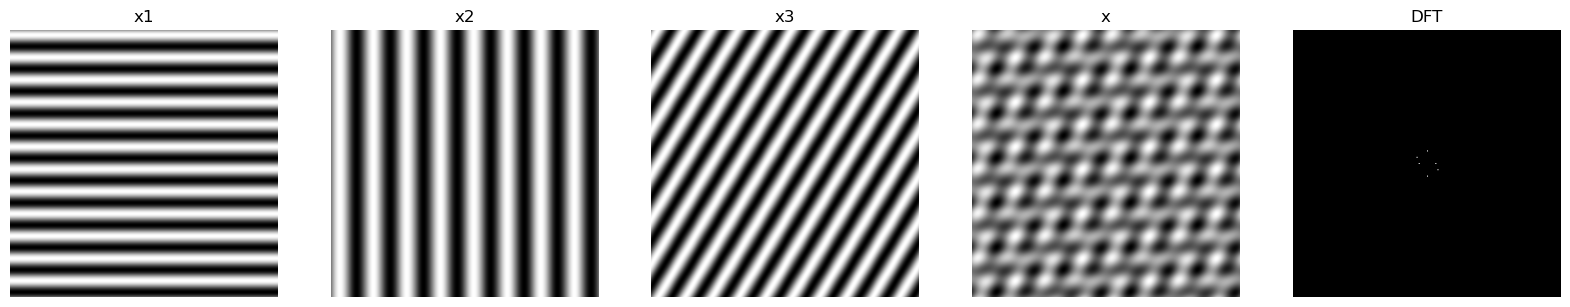

In [6]:
# 1.a) Plotting the images and DFT of x
fig,axes = plt.subplots(nrows=1, ncols=5, figsize=(20,8))
axes[0].imshow(x1, cmap='gray')
axes[0].axis('off')
axes[0].set_title("x1")
axes[1].imshow(x2, cmap='gray')
axes[1].axis('off')
axes[1].set_title("x2")
axes[2].imshow(x3, cmap='gray')
axes[2].axis('off')
axes[2].set_title("x3")
axes[3].imshow(x, cmap='gray')
axes[3].axis('off')
axes[3].set_title("x")
axes[4].imshow(DFT_x_magnitude, cmap='gray')
axes[4].axis('off')
axes[4].set_title("DFT")


In [7]:
threshold = [(-20, 20), (70, 110), (25, 65)]
filters = [np.zeros((M,M), dtype=np.float64), np.zeros((M,M), dtype=np.float64), 
           np.zeros((M,M), dtype=np.float64), np.zeros((M,M), dtype=np.float64)]

In [8]:
for tindex in range(len(threshold)):
    for i in range(M):
        for j in range(M):
            radian = np.arctan2(i - (M/2), j - (M/2))
            deg = np.rad2deg(radian)
            if deg >= threshold[tindex][0] and deg <= threshold[tindex][1]:
                filters[tindex][i,j] = 1


In [9]:
filters[3] = np.maximum(np.maximum(filters[0], filters[1]), filters[2])

Mean square error between the image x and convoluted image is: 0.1666666666666666
Mean square error between the image x and convoluted image is: 0.1666666666666666
Mean square error between the image x and convoluted image is: 0.18055555555555552
Mean square error between the image x and convoluted image is: 0.18055555555555552


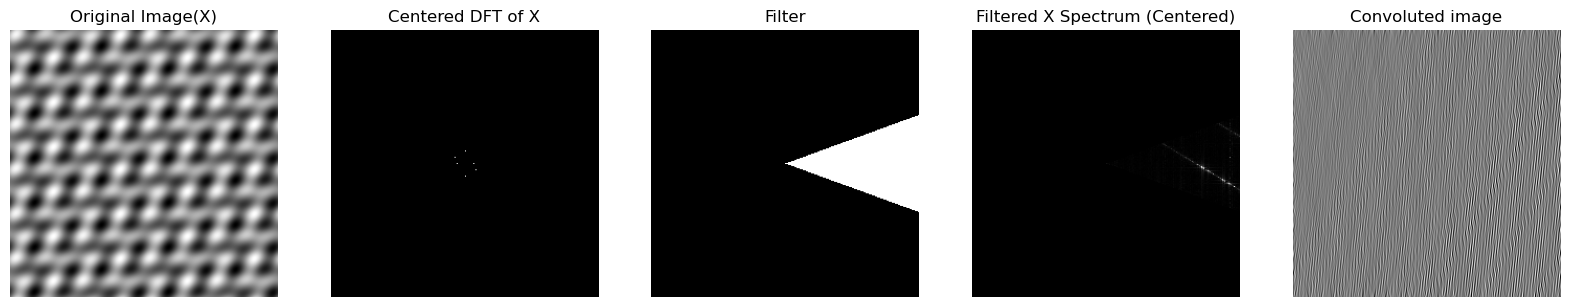

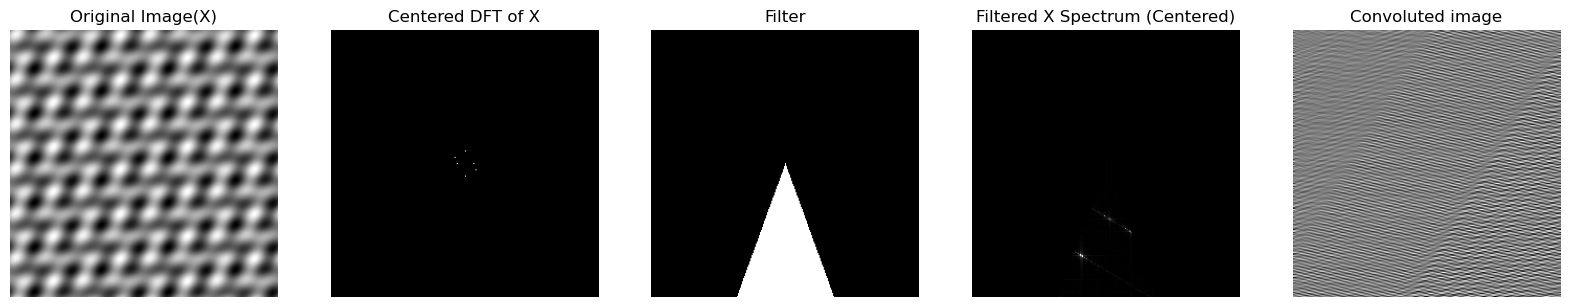

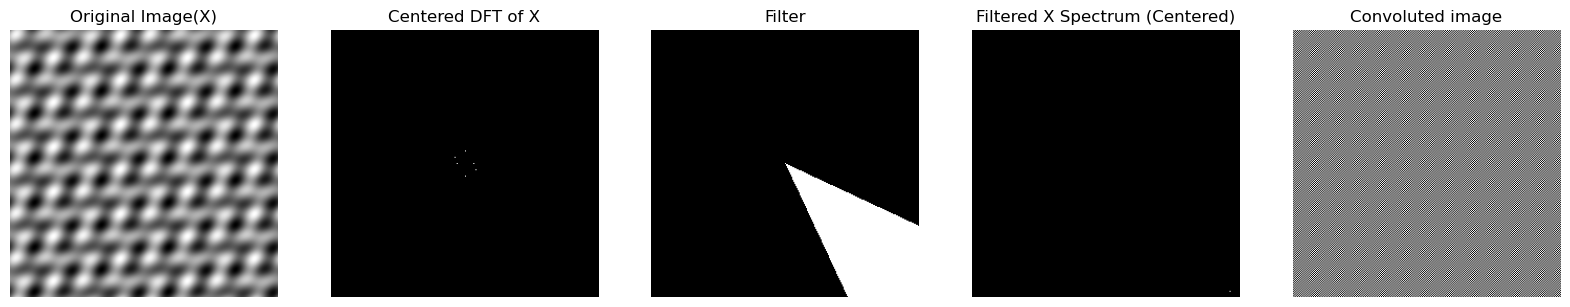

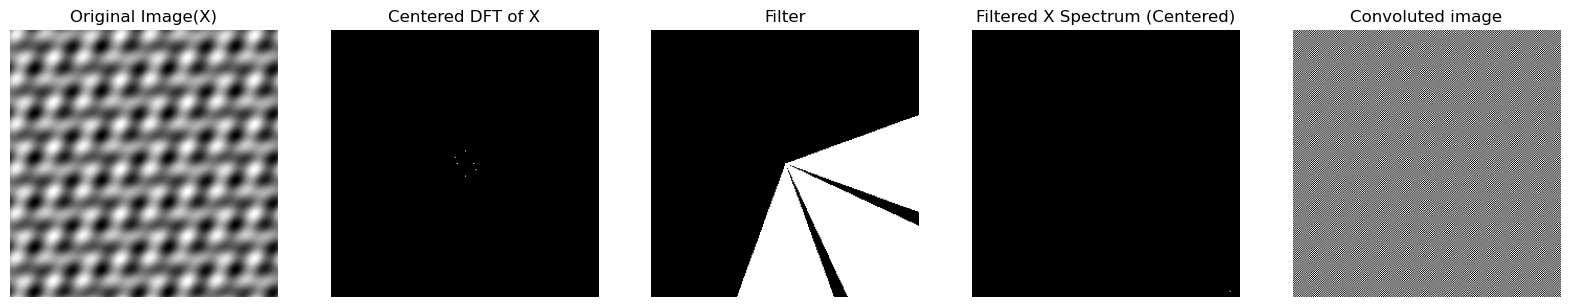

In [10]:
for h in filters:
    h[M//2, M//2] = 1
    G = DFT_x * h
    img = np.fft.ifft2(np.fft.ifftshift(G))

    fig,axes = plt.subplots(nrows=1, ncols=5, figsize=(20,8))
    axes[0].imshow(x, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("Original Image(X)")
    axes[1].imshow(np.log(1 + np.abs(DFT_x_center)), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title("Centered DFT of X")
    axes[2].imshow(h, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title("Filter")
    axes[3].imshow(np.log(1 + np.abs(G)), cmap='gray')
    axes[3].axis('off')
    axes[3].set_title("Filtered X Spectrum (Centered)")
    axes[4].imshow(np.real(img), cmap='gray')
    axes[4].axis('off')
    axes[4].set_title("Convoluted image")

    mse = np.sum((x - np.real(img)) ** 2) / (img.shape[0] * img.shape[1])
    print(f"""Mean square error between the image x and convoluted image is: {mse}""")

# Q2 Gaussian Blurring and Inverse Filtering:

In [11]:
img = np.array(Image.open("images/buildings.jpg").convert('L'))
img.shape

(1024, 1024)

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

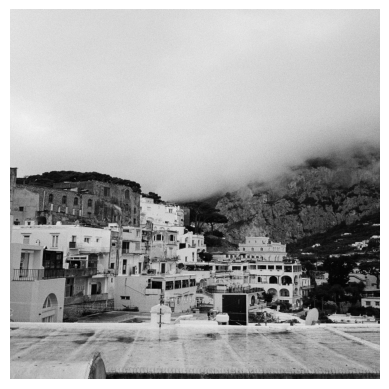

In [12]:
plt.imshow(img, cmap="gray")
plt.axis("off")

In [13]:
def gaussianKernel(size = 13, sigma = 2.5):
    kernel = np.zeros((size, size), dtype=np.float32)

    for i in range(size):
        for j in range(size):
            # finding the centered cords for gaussian calculation
            x = i - ((size - 1) // 2)
            y = j - ((size - 1) // 2)

            kernel[i,j] = np.exp(-((x**2) + (y**2)) / (2 * (sigma ** 2)))
    
    kernel /= np.sum(kernel)
    return kernel
    

### 2.a) Apply Blur in Frequency Domain

In [14]:
blur_img = scipy.ndimage.convolve(img, gaussianKernel(), mode="constant")
blur_img.shape

(1024, 1024)

In [39]:
filter = gaussianKernel(size = 13, sigma = 2.5)
filter.shape

(13, 13)

In [40]:
#padding lenth determination
padding = img.shape[0] + filter.shape[0] - 1    # min this much padding required to prevent circular convolution
img_pad_len = padding - img.shape[0]
filter_pad_len = padding - filter.shape[0]

In [41]:
img_pad = np.pad(img, ((0, img_pad_len), (0, img_pad_len)))
img_pad.shape

(1036, 1036)

In [51]:
filter_pad_left = (padding // 2) - (filter.shape[0] // 2)
filter_1036x1036_pad = np.pad(filter, ((filter_pad_left, filter_pad_len - filter_pad_left), (filter_pad_left, filter_pad_len - filter_pad_left)))
# filter_1036x1036_pad = np.pad(filter, ((511, 512), (511, 512)))
filter_1036x1036_pad_uncentered = np.fft.ifftshift(filter_1036x1036_pad)
img_pad.shape, filter_1036x1036_pad_uncentered.shape


((1036, 1036), (1036, 1036))

In [52]:
# FFT
img_fft = np.fft.fft2(img_pad)
filter_1036x1036_fft = np.fft.fft2(filter_1036x1036_pad_uncentered)
res_img_fft = img_fft * filter_1036x1036_fft
res_img = np.fft.ifft2(res_img_fft)
# cropped_res_img = res_img[img_pad_len//2 : img_pad_len//2 + img.shape[0], img_pad_len//2 : img_pad_len//2 + img.shape[1]] #cropping back to get the original dimension image
cropped_res_img = res_img

Text(0.5, 1.0, 'FFT of Convoluted image (Centered)')

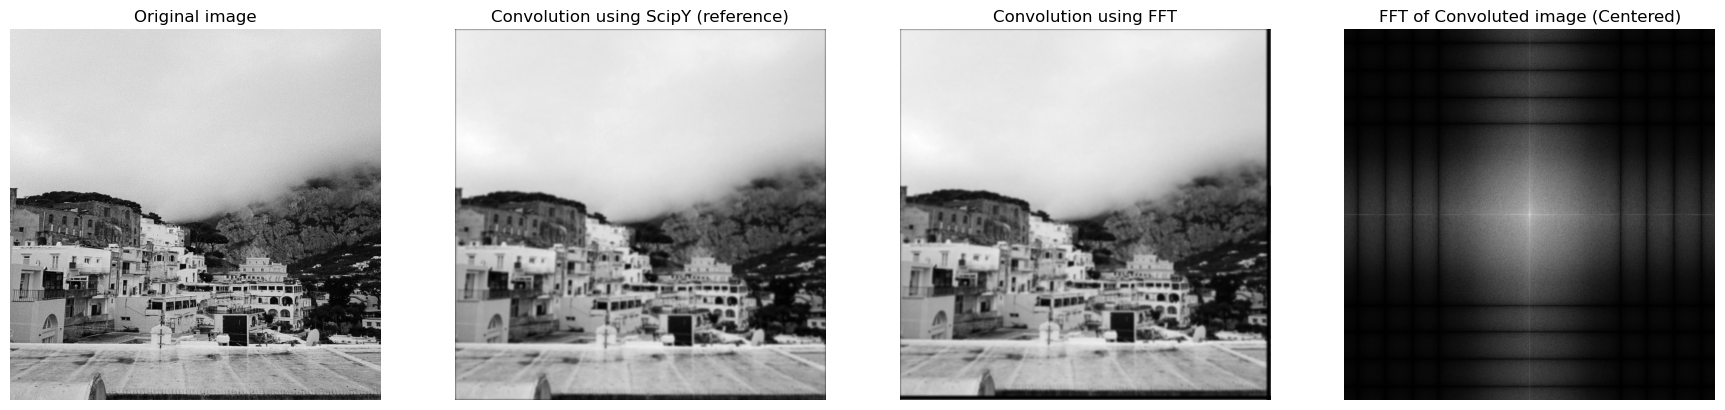

In [53]:
fig,axes = plt.subplots(nrows=1, ncols=4, figsize=(22,10))
axes[0].imshow(img, cmap='gray')  
axes[0].axis('off')
axes[0].set_title("Original image")
axes[1].imshow(scipy.ndimage.convolve(img, filter, mode="constant"), cmap='gray')  
axes[1].axis('off')
axes[1].set_title("Convolution using ScipY (reference)")
axes[2].imshow(np.real(cropped_res_img), cmap='gray')  
axes[2].axis('off')
axes[2].set_title("Convolution using FFT")
axes[3].imshow(np.log(1 + np.abs(np.fft.fftshift(res_img_fft))**(1/2)), cmap='gray')  
axes[3].axis('off')
axes[3].set_title("FFT of Convoluted image (Centered)")

##### FFT of convoluted image perfectly shows that higher frequency are not present and lower frequence is present

### 2.b) Visualize the Gaussian Kernel and its inverse

In [54]:
e = 0.001
filter_13x13_fft = np.fft.fft2(filter)

#inverse Filter
inverse_filter_13x13_fft = 1 / (np.abs(filter_13x13_fft) + e)
inverse_filter_1036x1036_fft = 1 / (np.abs(filter_1036x1036_fft) + e)


Text(0.5, 1.0, 'DFT of Inverse Gaussian (1036x1036)')

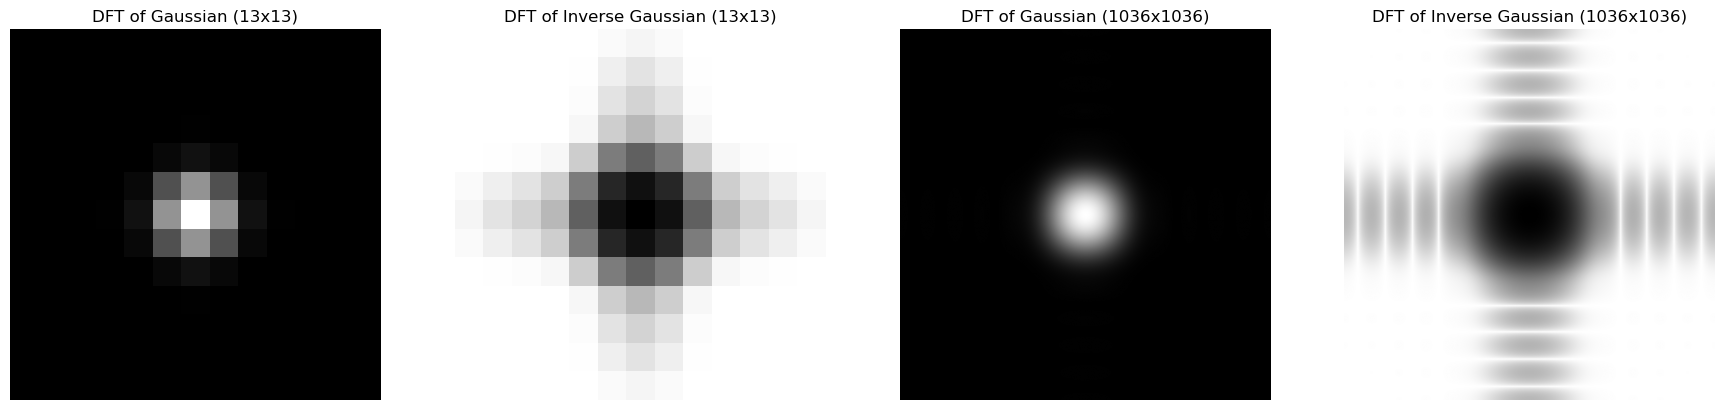

In [55]:
fig,axes = plt.subplots(nrows=1, ncols=4, figsize=(22,10))

axes[0].imshow(np.log(1 + np.abs(np.fft.fftshift(filter_13x13_fft))), cmap='gray')  
axes[0].axis('off')
axes[0].set_title("DFT of Gaussian (13x13)")

axes[1].imshow(np.log(1 + np.abs(np.fft.fftshift(inverse_filter_13x13_fft))), cmap='gray')  
axes[1].axis('off')
axes[1].set_title("DFT of Inverse Gaussian (13x13)")

axes[2].imshow(np.log(1 + np.abs(np.fft.fftshift(filter_1036x1036_fft))), cmap='gray')  
axes[2].axis('off')
axes[2].set_title("DFT of Gaussian (1036x1036)")

axes[3].imshow(np.log(1 + np.abs(np.fft.fftshift(inverse_filter_1036x1036_fft))), cmap='gray')  
axes[3].axis('off')
axes[3].set_title("DFT of Inverse Gaussian (1036x1036)")

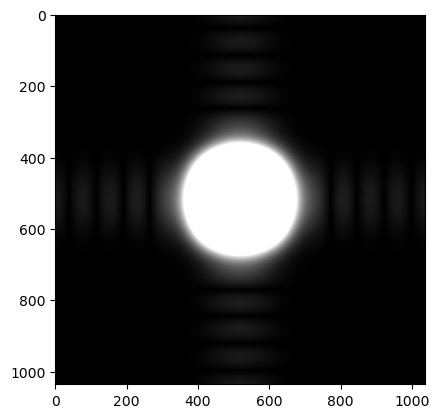

In [579]:
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(filter_1036x1036_fft))), cmap='gray', vmin = 0, vmax = 0.05)  

#### 13x13 Gaussian is ideal infinite gaussian x 13x13 window -> convolution of these 2 in FD. 1036x1036 is gaussian in high resolution sampling is done, because 0 doesnt have a frequency.

### 2.c) Find the best fit of Gaussian 1036x1036 filter

In [450]:
np.sum(np.abs(filter_13x13_fft))

np.float32(4.417653)

In [519]:
# pre - calculating (U^2 + V^2)
filter_size = filter_1036x1036_fft.shape[0]
u, v = np.indices((filter_size, filter_size))
u = u - ((filter_size - 1) / 2)
v = v - ((filter_size - 1) / 2)
uv2 = u**2 + v**2

In [620]:
min_error = np.inf
k_optimal = 0
filter_1036x1036_fft_center = np.fft.fftshift(filter_1036x1036_fft)  #centering the Filter to calculate the error below
for k in (np.linspace(1e-6, 1e-3, 1000)):
    H_cont = np.exp( -k * uv2)
    error = np.sum((H_cont - np.abs(filter_1036x1036_fft_center)) ** 2)
    if error <= min_error:
        k_optimal = k
        min_error = error

In [635]:
H_cont = np.exp( -(k_optimal) * uv2)
inv_H_cont = 1 / (np.abs(H_cont) + e)

Text(0.5, 1.0, 'DFT of Inverse Gaussian (13x13)')

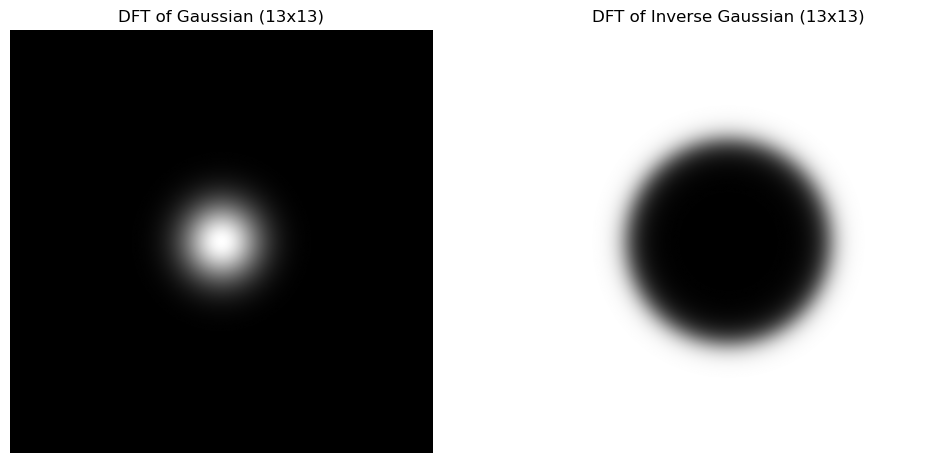

In [636]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

axes[0].imshow(H_cont, cmap='gray')  
axes[0].axis('off')
axes[0].set_title("DFT of Gaussian (13x13)")

axes[1].imshow(inv_H_cont, cmap='gray')  
axes[1].axis('off')
axes[1].set_title("DFT of Inverse Gaussian (13x13)")

Text(0.5, 1.0, 'DFT of Gaussian (1036x1036)')

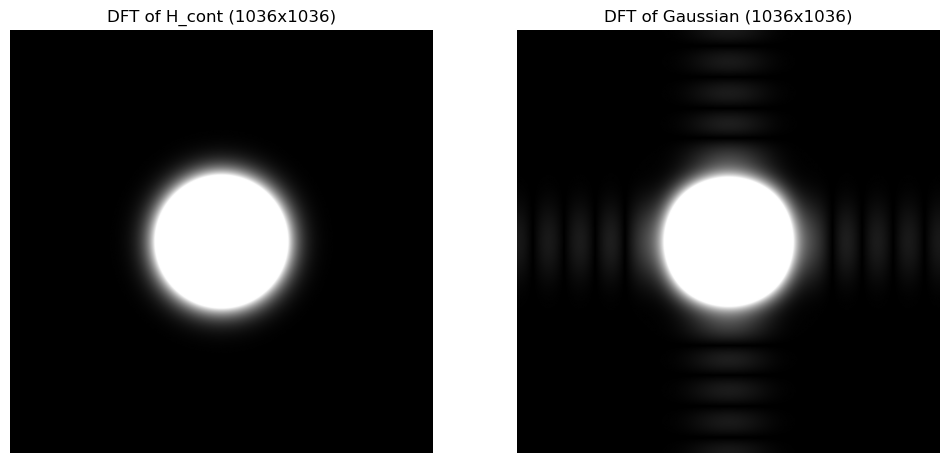

In [637]:
# Conclusion - Difference between Gaussian Fit Filter and Direct Gaussian Filter
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

axes[0].imshow(H_cont, cmap='gray', vmin = 0, vmax = 0.05)  
axes[0].axis('off')
axes[0].set_title("DFT of H_cont (1036x1036)")

axes[1].imshow(np.log(1 + np.abs(np.fft.fftshift(filter_1036x1036_fft))), cmap='gray', vmin = 0, vmax = 0.05)  
axes[1].axis('off')
axes[1].set_title("DFT of Gaussian (1036x1036)")

## 2.d) Image Resstoration

In [658]:
res_img_inv_gauss_fft = res_img_fft * inverse_filter_1036x1036_fft
inv_H_cont_unshifted = np.fft.ifftshift(inv_H_cont)                      # Making the DFT unshifted
res_img_inv_Hcont_fft = res_img_fft * inv_H_cont_unshifted

#restoring Image
res_img_inv_gauss = np.clip(np.real(np.fft.ifft2(res_img_inv_gauss_fft)), 0, 255)[img_pad_len//2 : img_pad_len//2 + img.shape[0], img_pad_len//2 : img_pad_len//2 + img.shape[1]]
res_img_inv_Hcont = np.clip(np.real(np.fft.ifft2(res_img_inv_Hcont_fft)), 0, 255)[img_pad_len//2 : img_pad_len//2 + img.shape[0], img_pad_len//2 : img_pad_len//2 + img.shape[1]]

Text(0.5, 1.0, 'Restored Image - Inverse Gauss Fit')

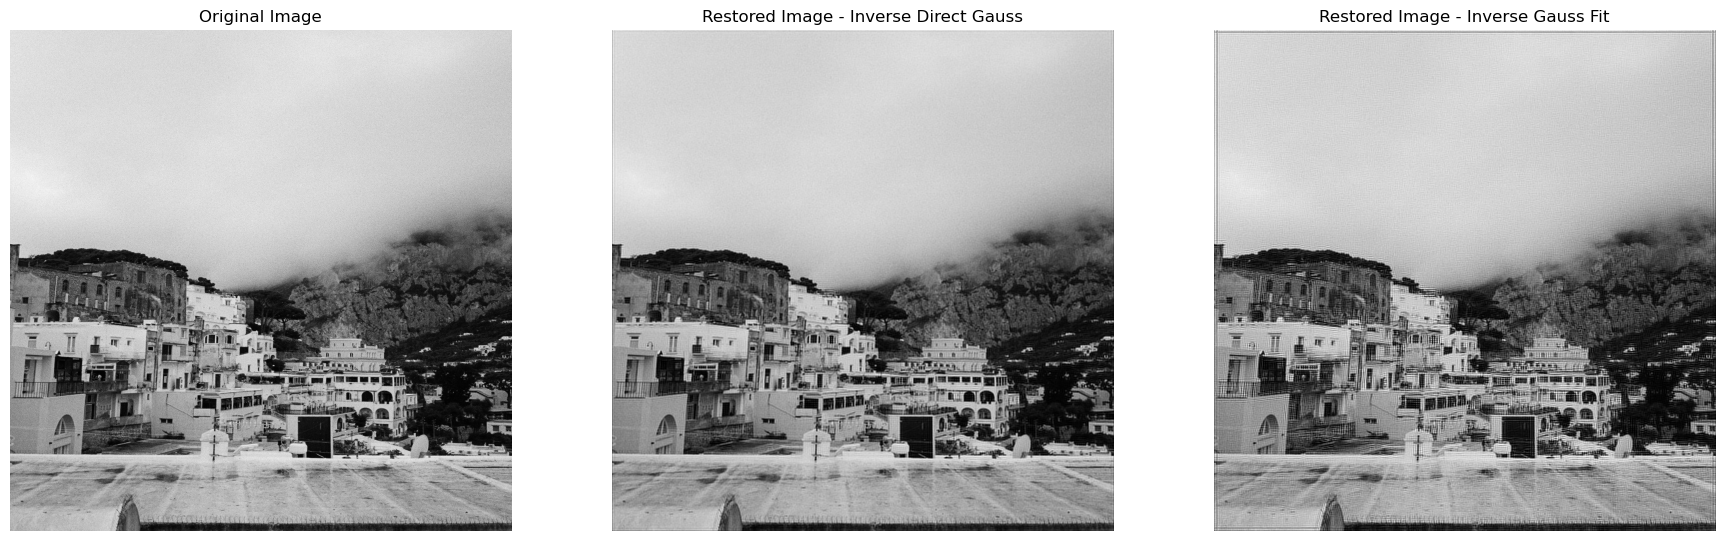

In [660]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(22,10))

axes[0].imshow(img, cmap='gray')  
axes[0].axis('off')
axes[0].set_title("Original Image")


axes[1].imshow(np.real(res_img_inv_gauss), cmap='gray')  
axes[1].axis('off')
axes[1].set_title("Restored Image - Inverse Direct Gauss")

axes[2].imshow(np.real(res_img_inv_Hcont), cmap='gray')  
axes[2].axis('off')
axes[2].set_title("Restored Image - Inverse Gauss Fit")

In [ ]:
# Calculating MSE
error_res_img_inv_gauss = np.sum((img - res_img_inv_gauss) ** 2) / (img.shape[0] ** 2)
error_res_img_inv_Hcont = error = np.sum((img - res_img_inv_Hcont) ** 2) / (img.shape[0] ** 2)

print(f"""MSE between the original Image and Restored Image using the inverse Direct Gaussian Filter is: {error_res_img_inv_gauss} """)
print(f"""MSE between the original Image and Restored Image using the Inverse Gaussian Fit Filter is: {error_res_img_inv_Hcont} """)


MSE between the original Image and Restored Image using the inverse Direct Gaussian Filter is: 174.0749396368524 
MSE between the original Image and Restored Image using the Inverse Gaussian Fit Filter is: 716.9446324866917 
